## DEMO - Training eines CNN

Verwendung in der Projektphase 2

Das Notebook zeigt beispielhaft die Durchführung folgender Schritte mit Keras:
- Vorverarbeitungsschritte der Bilder
- Trainieren eines CNNs
- Speichern und Laden
- Anwendung
- Transformation in ein TF-lite-Modell

Die verwendeten Bilder befinden sich in `/gitignore/data/images`.

In [25]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from os import listdir,path
import cv2

In [26]:
# Lesen der Filenamen der Bilder in einem Ordner    
img_path = './bilder_nn/' # greift auf ordner bilder__nn zu 
img_files = listdir(img_path)
#print(img_files)
len(img_files) , len(set(img_files))

(703, 703)

In [27]:
img_files = listdir(img_path)

[[[254 250 217]
  [222 218 185]
  [240 237 198]
  ...
  [ 77 101  84]
  [ 77 104  86]
  [ 80 107  89]]

 [[253 249 216]
  [210 206 173]
  [218 215 176]
  ...
  [ 73  97  80]
  [ 72  99  81]
  [ 68  95  77]]

 [[254 249 215]
  [212 207 173]
  [231 226 186]
  ...
  [ 73  97  80]
  [ 72  97  78]
  [ 69  94  75]]

 ...

 [[220 244 217]
  [ 32  56  29]
  [ 53  81  43]
  ...
  [107 132  87]
  [111 133  89]
  [108 130  86]]

 [[220 244 217]
  [ 31  55  28]
  [ 56  84  46]
  ...
  [108 133  88]
  [111 133  89]
  [108 130  86]]

 [[220 244 217]
  [ 33  57  30]
  [ 54  82  44]
  ...
  [108 133  88]
  [110 132  88]
  [110 132  88]]]
(480, 640, 3)


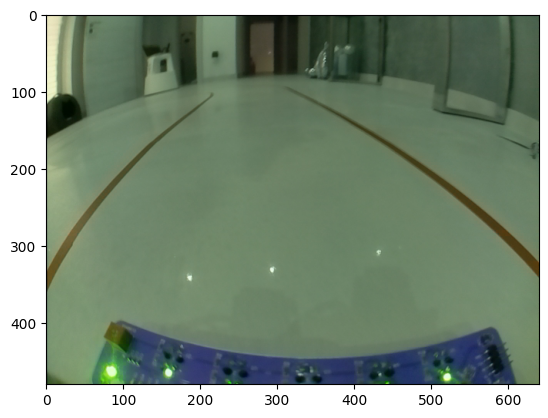

In [28]:
# Ansicht eines Beispielbildes (rot grün vertauscht)
img_example = cv2.imread(img_path + img_files[10])
print(img_example)
plt.imshow(img_example)
print(img_example.shape)

In [29]:
# Testweises Einlesen aller Bilder -> Kontrolle der Anzahl
imgs_test = np.array([cv2.imread(img_path+i) for i in img_files])
imgs_test.shape

(703, 480, 640, 3)

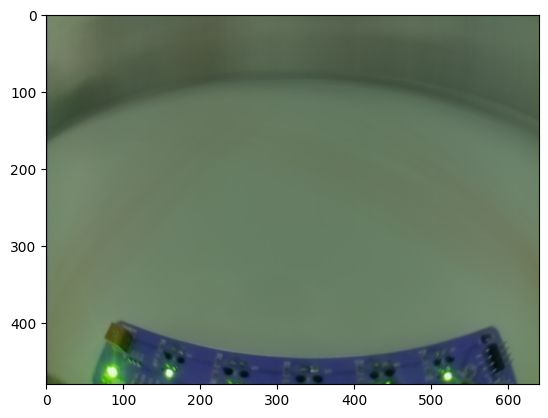

In [30]:
# Mittleres Bilder der Trainingsbilder
img_mean = imgs_test.mean(axis=0).astype('int')
plt.imshow(img_mean)

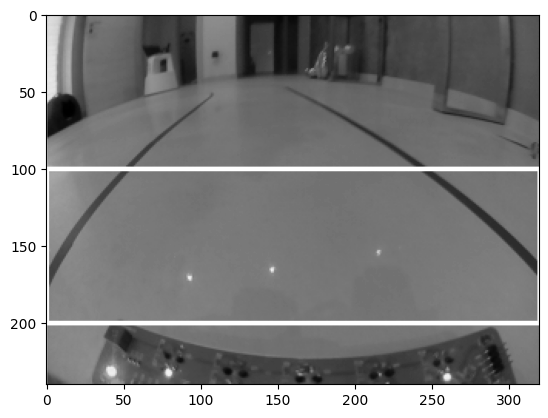

In [31]:
# Testweise Bildbearbeitung
sp=(0,200)
ep=(320,100)
dim = (320,240)
interpolation = cv2.INTER_AREA
img_example_x = img_example.copy()
img_example_x = cv2.cvtColor(img_example_x,cv2.COLOR_BGR2GRAY)
img_example_x= cv2.resize(img_example_x,dim,interpolation)
#plt.imshow(img_example_x)
plt.imshow(cv2.rectangle(img_example_x,sp,ep,(255,255,0),2),cmap='gray')

In [32]:
# Definition einer Funktion zur Vorverarbeitung der Trainingsbilder
def transform_image(img):
    dim = (320,240)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Verwendung von Graustufenbildern
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    img = img[100:200,:] # Ausschneiden eines Teilbildes
    return img

In [33]:
# Alternative für verkleinert Bilder
# Definition einer Funktion zur Vorverarbeitung der Trainingsbilder
def transform_image_small(img):
    dim = (64,48)
    interpolation = cv2.INTER_AREA
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Verwendung von Graustufenbildern
    img = cv2.resize(img,dim,interpolation) #  Anpassung der Bildgröße
    #img = img[100:200,:] # Ausschneiden eines Teilbildes
    img = img[20:40,:] # Ausschneiden eines Teilbildes
    return img

In [34]:
# Laden und Vorverarbeiten aller Trainingsbilder
imgs = np.array([transform_image_small(cv2.imread(img_path+i)) for i in img_files])
imgs.shape

(703, 20, 64)

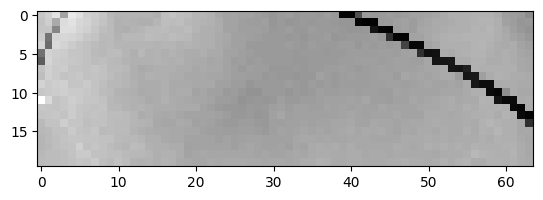

In [35]:
# Ansicht eines vorverarbeiteten Beispielbilder
plt.imshow(imgs[0],cmap='gray')

118.33204458570412
242
32


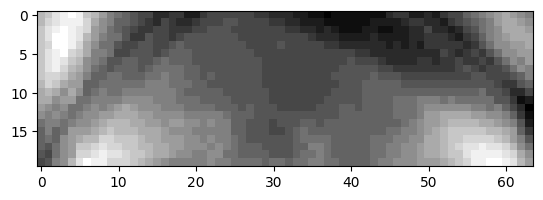

In [36]:
# Mittleres vorverarbeitetes Trainingsbild
plt.imshow(imgs.mean(axis=0).astype('int'),cmap='gray')
print(imgs.mean())
print(imgs.max())
print(imgs.min())

### Spiegeln der Bilder (Augmentation)

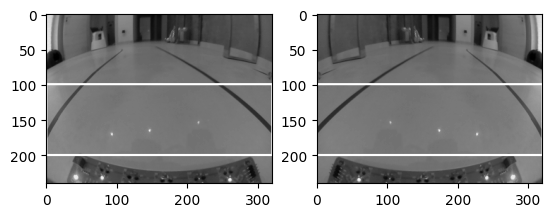

In [37]:
# Test Spiegeln eines Bildes
img_example_x_mirrored = img_example_x[:,::-1] # alternativ mit cv2.flip
plt.figure()
plt.subplot(121)
plt.imshow(img_example_x,cmap='gray')
plt.subplot(122)
plt.imshow(img_example_x_mirrored,cmap='gray')

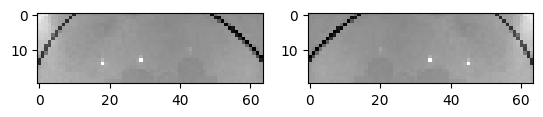

In [38]:
# Test Spiegeln eines vorverarbeiteten Bildes
imgs_mirrored = imgs[:,:,::-1]
plt.figure()
plt.subplot(121)
plt.imshow(imgs[10],cmap='gray')
plt.subplot(122)
plt.imshow(imgs_mirrored[10],cmap='gray')

In [39]:
# Zusammenfügen der ungespiegelten und der gespiegelten Trainingsdaten
print(imgs.shape)
print(imgs_mirrored.shape)
imgs_all = np.concatenate((imgs,imgs_mirrored))
print(imgs_all.shape)

(703, 20, 64)
(703, 20, 64)
(1406, 20, 64)


### "Spiegeln" der Lenkwinkel (Agumentation)
- inklusive des Ladens/Extrahierens der Lenkwinkel aus den Dateinamen

In [44]:
# Position des Lenkwinkels im Filenamen (abhängig vom OS!)
print(img_files[0].split("_")[-1][:-4])

def str_to_int(x):
    x.split("_")[-1][:-4]
# print('-',i[46:-4],'-') # Raspberry/Linux
# print('-',i[50:-4],'-') # Windows



90


In [ ]:
angles = np.array([int(i[46:-4]) for i in img_files]) # Extrahieren der Lenkwinkel aus dem Dateinamen
angles_mirrored = [-(a-90)+90 for a in angles] # Spiegeln der Winkel

# Kontrolle
plt.plot(angles,angles_mirrored)
angles_all = np.hstack((angles,angles_mirrored)) # Zusammenführen der ungespiegelten und gespiegelten Winkel

In [ ]:
angles_all

### Verteilung der Lenkwinkel

In [ ]:
pd.Series(angles_all, name ='angles').hist(bins = 40)

In [ ]:
# Kontrolle und Reshapen der Trainingsdaten
print(angles_all.shape)
print(imgs_all.shape)
n,h,w=imgs_all.shape
imgs_all = imgs_all.reshape((n,h,w,1)) # Convolutional Input-Layer benötigt diese Format/Shape
print(imgs_all.shape)

### Einteilen der Trainingsdaten

In [ ]:
# Split Trainings- und Testdaten
from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(imgs_all, angles_all, test_size = 0.2, random_state = 1)

### Erstellen des NN  mit Tensorflow

In [ ]:
# Korntrolle
print(X_train.dtype)
print(X_train.shape)
print(y_train.shape)
print(X_validate.dtype)
print(X_validate.shape)
print(X_validate.shape)

In [ ]:
# Import notwendiger Klassen und Funktionen
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# Kontrolle bzw. Ermitteln des Shape der Eingabedaten/Inputshape
n,h,w,f=imgs_all.shape
input_shape = (h,w,f)
print(input_shape)

In [ ]:
#input_shape=(10,32,1)

In [ ]:
# Erstellen des Netzes
# Keras Sequntial API
model = tf.keras.Sequential(name='dnn') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=input_shape, activation='elu')) 
model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu')) 
model.add(Dropout(0.2)) # more robustness 
model.add(Conv2D(64, (3, 3), activation='elu')) 

# Fully Connected Layers 
model.add(Flatten()) 
model.add(Dropout(0.2)) # more robustness 
model.add(Dense(100, activation='elu')) 
model.add(Dense(50, activation='elu')) 
model.add(Dense(10, activation='elu'))

# Output Layer: turning angle
model.add(Dense(1)) 


In [ ]:
# Alternative für kleiens Bild
# Erstellen des Netzes für das stark verkleinert Bild

n,h,w,f=imgs_all.shape
input_shape = (h,w,f)
print(input_shape)
# Keras Sequntial API
model_small = tf.keras.Sequential(name='dnn_small') 

# Convolution Layers 
# elu: Expenential Linear Unit, similar to leaky Relu 
model_small.add(Conv2D(10, (3, 3), strides=(2, 2), input_shape=input_shape, activation='elu')) 
model_small.add(Conv2D(20, (2, 2), strides=(2, 2), activation='elu'))
model_small.add(Conv2D(40, (2, 2), strides=(2, 2), activation='elu'))

# Fully Connected Layers 
model_small.add(Flatten()) 
model_small.add(Dropout(0.2)) # more robustness 
model_small.add(Dense(5, activation='elu')) 
model_small.add(Dense(5, activation='elu')) 

# Output Layer: turning angle
model_small.add(Dense(1)) 

In [ ]:
# Kontrolle der Architektur
model.summary()

### Trainieren des NN

In [ ]:
# Kompiliern des Modells und Wahl von Fehlerfunktion und Optimizer
model.compile(loss ='mse', optimizer=Adam(lr=0.001))

In [ ]:
# Training
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs= 50,
    verbose=1,
    validation_data=(X_validate,y_validate)
)

In [ ]:
def train_loss_acc_plot(history,skip=0):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'][skip:], label='Loss')
    plt.plot(history.history['val_loss'][skip:], label='Validation Loss')
    plt.legend()
    plt.title('Training - Loss Function')

In [ ]:
# Begutachtung des Trainingsverlaufs
train_loss_acc_plot(history,skip=10)

In [ ]:
# Eventuelle weiteres Training
history = model.fit(
    X_train,
    y_train,
    batch_size=200,
    epochs= 10,
    verbose=1,
    validation_split=.3
)

In [ ]:
# Trainings- und Testfehler
mse_train = model.evaluate(X_train,y_train)
mse_validate = model.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

In [ ]:
# Visualisierung der Fehler
y_train_p = model.predict(X_train)
y_validate_p = model.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

In [ ]:
# Speichern des trainierten Modells
path_to_model_file = './gitignore/data/model/DEMO_MODEL.h5'# Speichert im H5-Format
# path_to_model_file = './gitignore/data/model/DEMO_MODEL' # Speichert im SavedModel-Format
model.save(path_to_model_file)

## Verwendung eines trainierten Modells

In [ ]:
# Laden eines Modells
path_to_model_file = './gitignore/data/model/DEMO_MODEL.h5'
model_loaded = tf.keras.models.load_model(path_to_model_file)

In [ ]:
# Informationen über das Netz erhalten
#model_loaded.get_config()

In [ ]:
# Shape des Input-Layers
model_loaded.layers[0].input_shape

In [ ]:
mse_train = model_loaded.evaluate(X_train,y_train)
mse_validate = model_loaded.evaluate(X_validate,y_validate)

print('MSE train/val: {:.4f} / {:.4f}'.format(mse_train,mse_validate))
print('RMSE train/val: {:.4f} / {:.4f}'.format(np.sqrt(mse_train),np.sqrt(mse_validate)))

In [ ]:
# Visualisierung der Fehler
y_train_p = model_loaded.predict(X_train)
y_validate_p = model_loaded.predict(X_validate)
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(y_train,y_train_p,'rx',ms=2)
plt.plot([45,135],[45,135],'k-')
plt.subplot(122)
plt.plot(y_validate,y_validate_p,'bx',ms=2)
plt.plot([45,135],[45,135],'k-')

### Anwendung des Netzes zur Bestimmung des Lenkwinkels

In [ ]:
# Wahl eines Beispielbildes!
xe = np.array( [X_train[0]] )
xe.shape

In [ ]:
# Mittels der Methode predict
model_loaded.predict(xe)

In [ ]:
# Mittels der Methode __call__ 
model_loaded(xe).numpy()

In [ ]:
model_loaded.__call__(xe)

### Ausführungsgeschwindigkeit

In [ ]:
# langsam
%timeit model_loaded.predict(xe)

In [ ]:
# schneller
%timeit model_loaded(xe).numpy()

## Model als Tensorflow-lite-Modell speichern

In [ ]:
# Speichern des Modells im TF-eigenen Format
# -> erzeugt Ordner mit Daten des Modells
#path_to_model_tf_format = './gitignore/data/model/DEMO_MODELL_saved_on_RPI'
path_to_model_tf_format = './gitignore/data/model/DEMO_MODELL'
#model.save(path_to_model_tf_format)
#model_loaded.save(path_to_model_tf_format)

In [ ]:
path_to_model_tf_format = './gitignore/data/model/DEMO_MODELL'
converter = tf.lite.TFLiteConverter.from_saved_model(path_to_model_tf_format)
#converter = tf.lite.TFLiteConverter.from_keras_model(model_loaded)

In [ ]:
tflite_model = converter.convert()
# This step fails on my RPI, but works in WinPython. Rob.

In [ ]:
path_to_model_tf_format = './gitignore/data/model/DEMO_MODEL.tflite'
with open(path_to_model_tf_format, 'wb') as f:
    f.write(tflite_model)

In [ ]:
print(angles[0])
plt.imshow(imgs[0],cmap='gray')

In [ ]:
path = './data/some_images_used_by_nb_Using_Tensorflow_lite/'
for i in [1,10,100]:
    name = f"image_{i}_angle_{str(angles[i])}"
    print(name)
    cv2.imwrite(path+name+'.jpg',imgs[i])